# Visualize learning

Let's try to use the same old `plot_weights` function to plot our new network's weights. We need a few fixes to make it work, because the weights are not exactly the same as our previous model.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import math
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 28 * 28])
y_ = tf.placeholder(tf.float32, [None, 10])

W1 = tf.Variable(tf.truncated_normal([28 * 28, 300], stddev=1 / math.sqrt(28 * 28)))
b1 = tf.Variable(tf.constant(0.1, shape=[300]))
h = tf.sigmoid(tf.matmul(x, W1) + b1)

W2 = tf.Variable(tf.truncated_normal([300, 10], stddev=1 / math.sqrt(300)))
b2 = tf.Variable(tf.constant(0.1, shape=[10]))
y = tf.nn.softmax(tf.matmul(h, W2) + b2)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), axis=1))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


/Users/jaksherm/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jaksherm/anaconda/envs/tensorflow/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


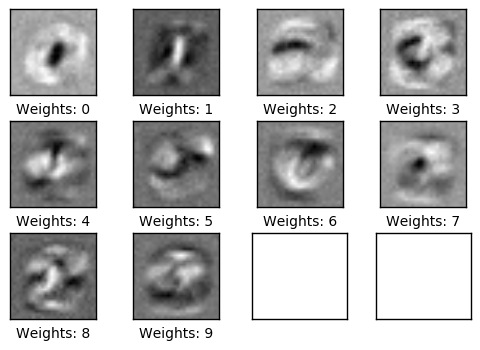

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_weights(session, w1, w2, img_shape=(28, 28)):
    w = session.run(tf.matmul(w1, w2))

    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, axis in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i < 10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            axis.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            axis.imshow(image, cmap='gray')

        # Remove ticks from each sub-plot.
        axis.set_xticks([])
        axis.set_yticks([])
        
plot_weights(sess, W1, W2)

## TensorBoard

As you've seen before, with little effort and a few lines of code, we are capable of making a computer able to recognize handwritten digits with some confidence. At this point, however, we don't have much control on the model we have created. Actually, we are not even sure it performs as it should.

One way to visualize what we are doing with our operation graph, training loop and so on is to leverage the power of [TensorBoard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/), which is a suite of visualization tools easily pluggable into your TensorFlow model.

TensorBoard operates by reading TensorFlow events files, which contain summary data that we can generate when running TensorFlow with special summary operations. Summary operations can serialize our data in multiple ways, be our data images, audio, histograms or distributions. Again, defining a summary operation doesn't do much, so we need to merge all summaries before a `tf.train.SummaryWriter` can actually serialize our data for us into log files.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import math
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 28 * 28], name='input_images')
y_ = tf.placeholder(tf.float32, [None, 10], name='labels')

tf.summary.image('input', tf.reshape(x, [-1, 28, 28, 1]))
W1 = tf.Variable(tf.truncated_normal([28 * 28, 300], stddev=1 / math.sqrt(28 * 28)), name='L1_weights')
b1 = tf.Variable(tf.constant(0.1, shape=[300]), name='L1_biases')
h = tf.sigmoid(tf.matmul(x, W1) + b1, name='sigmoid')
tf.summary.histogram('L1_weights', W1)

W2 = tf.Variable(tf.truncated_normal([300, 10], stddev=1 / math.sqrt(300)), name='L2_weights')
b2 = tf.Variable(tf.constant(0.1, shape=[10]), name='L2_biases')
logits = tf.matmul(h, W2) + b2
y = tf.nn.softmax(logits, name='softmax')
tf.summary.histogram('L2_weights', W2)
tf.summary.histogram('logits', logits)
tf.summary.histogram('output', y)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), axis=1), name='cross_entropy')
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
tf.summary.scalar('loss', cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1), name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='train_accuracy')
tf.summary.scalar('accuracy', accuracy)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
merged_summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter('./summary/train', sess.graph)
sess.run(init)
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _, summary = sess.run([train_step, merged_summaries], feed_dict={x: batch_xs, y_: batch_ys})
    summary_writer.add_summary(summary, i)

print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9234


## Exercise 2

Let's experiment with the network by adding another hidden layer, with weights and biases initialized in the way you prefer. You can choose the activation functions to be sigmoids or ReLUs (`tf.nn.relu(features)`). Also, let's try to introduce dropout in order to reduce overfitting.

![dropout](images/dropout.png "Dropout")

In order to do that, we could use a float placeholder, receiving the probability for a node to be dropped from the network during training.

```
drop_prob = tf.placeholder(tf.float32)
dropped = tf.nn.dropout(layer, 1.0 - drop_prob)
```

Of course, we'd need to add a `drop_prob` field into the `feed_dict` we use to feed our model.
Finally, use summaries in order to visualize what you're doing with TensorBoard. Save the logs into the `./summary/dropout` directory.

We'll review the solution in 15 minutes.

In [ ]:
import math
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 28 * 28], name='input_images')
y_ = tf.placeholder(tf.float32, [None, 10], name='labels')

# 2nd layer
tf.summary.image('input', tf.reshape(x, [-1, 28, 28, 1]))
W1 = tf.Variable(tf.truncated_normal([28 * 28, 300], stddev=1 / math.sqrt(28 * 28)), name='L1_weights')
b1 = tf.Variable(tf.constant(0.1, shape=[300]), name='L1_biases')
h = tf.sigmoid(tf.matmul(x, W1) + b1, name='sigmoid')
tf.summary.histogram('L1_weights', W1)

# 3rd layer
W2 = tf.Variable(tf.truncated_normal([300, 10], stddev=1 / math.sqrt(300)), name='L2_weights')
b2 = tf.Variable(tf.constant(0.1, shape=[10]), name='L2_biases')
logits = tf.matmul(h, W2) + b2
y = tf.nn.softmax(logits, name='softmax')
tf.summary.histogram('L2_weights', W2)
tf.summary.histogram('logits', logits)
tf.summary.histogram('output', y)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), axis=1), name='cross_entropy')
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
tf.summary.scalar('loss', cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1), name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='train_accuracy')
tf.summary.scalar('accuracy', accuracy)

init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
merged_summaries = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter('./summary/train', sess.graph)
sess.run(init)
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _, summary = sess.run([train_step, merged_summaries], feed_dict={x: batch_xs, y_: batch_ys})
    summary_writer.add_summary(summary, i)

print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))